In [2]:
import pandas as pd
import numpy as np
import math as m
import time 
from pycowview.data import csv_read_FA
from pycowview.manipulate import unique_cows
from pycowview.metrics import interaction_time
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import os
import community
from collections import defaultdict
import progressbar
import random
import cv2
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests


In [3]:
# This function will get the path of each csv file
def findAllFile(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            if f.endswith('.csv'):
                fullname = os.path.join(root, f)
                yield fullname

In [4]:
# Input is the folders where the time matrix and cowlist are saved
# Output is a list which consists of 14 dictionaries
# The structure of dictionary:Cowlist,TimeMatrix,AajacencyMatrix_binary,Unweighted_Graph
def time_matrix_to_graph(tm_folder,cl_folder):
    dict_list = []
    #i = 0
    for tm,cl in zip(findAllFile(tm_folder),findAllFile(cl_folder)):
        # print(tm,cl)
        # Get the path of csv
        # get cowlist
        cowlist = np.loadtxt(cl,delimiter=",").astype(int)
        # load original time matrix from csv and process it to be an adjacency Matrix
        OM = np.loadtxt(tm,delimiter=",")
        
        # Get unweighted adjacency matrix(binary)
        # init adjacency matrix
        AM = np.zeros((OM.shape))
        # set the threshold to be 30 minutes(1800 seconds)
        epsilon = 1800
        # just consider if there is an edge between two cows, the edge is unweighted
        AM[OM >= epsilon] = 1
        AM[OM < epsilon] = 0
        
        # Get graph from AM, no-direct and no-weight graph
        G_AM_temp = nx.from_numpy_matrix(AM,parallel_edges=False,create_using = nx.Graph())
        # Make sure the order of cowlist is the same as the row name!
        mapping = dict(zip(G_AM_temp, cowlist))
        # Rename the nodes
        G_AM = nx.relabel_nodes(G_AM_temp, mapping)
        
        # Get the dict of the collection(CL,TM,AM_binary,Graph)
        data_dict = dict(CL=cowlist,TM=OM,AM_binary=AM,Graph=G_AM)
        #i = i + 1
        dict_list.append(data_dict)
    #print(i)
    print('The length of the list: ',len(dict_list))
    return dict_list

In [5]:
# This part is used to process the time matrices
tm_folder = './time_matrix'
cl_folder = './cow_list'
data_dict_list = time_matrix_to_graph(tm_folder,cl_folder)

The length of the list:  14


In [6]:
def own_degree_hist(G,max_degree):
    degrees = [G.degree(n) for n in G.nodes()]
    hist, bins = np.histogram(degrees, bins = max_degree, range = (0, max_degree))
    return hist
    

In [7]:
#Create the histogram
max_degree = 27
hist = {}
bins = {}
for i in range(len(data_dict_list)):
    hist[i] = own_degree_hist(data_dict_list[i].get('Graph'), max_degree)

In [38]:
# Compare histograms and calculate the mean of probabilities that the histograms are from the same distribution
results = np.zeros((len(data_dict_list),len(data_dict_list)))
p = np.zeros((len(data_dict_list),len(data_dict_list)))
p_sum = 0
m = 0
test_P = np.zeros(len(data_dict_list)*(len(data_dict_list)-1))
for i in range(len(data_dict_list)):
    for j in range(len(data_dict_list)):
        if not (i==j):
            results[i][j], p[i][j] = stats.ks_2samp(hist[i], hist[j])
            p_sum += p[i][j]
            test_P[m] = p[i][j]
            m += 1

p_adjusted = multipletests(test_P, alpha = 0.05, method='bonferroni', is_sorted=False)
psum = sum(p_adjusted[0])
print((len(test_P)-psum)/len(test_P))
print(p_adjusted)
#p_sum = p_sum/((len(data_dict_list)-1)*len(data_dict_list))
#print(f'The probability that two sets of samples were drawn from the same (but unknown) probability distribution: {p_sum}')

1.0
(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, F

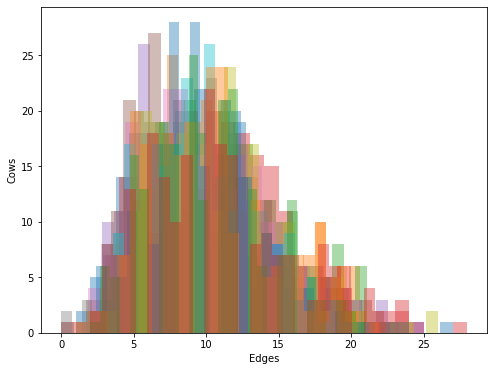

In [19]:
# Plot all days in one histogram
plt.figure(figsize=(8,6))
for i in range(len(data_dict_list)):
    G = data_dict_list[i].get('Graph')
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins = 28, alpha = 0.4)
plt.xlabel('Edges')
plt.ylabel('Cows')
plt.savefig('./community/Hist/AllDay.png')

In [10]:
# Plot and save a single days histogram
def hist_degree_dist(G, day):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, max(degrees)-min(degrees))
    plt.xlabel('Edges')
    plt.ylabel('Cows')
    plt.title(f'Day {day+1}')
    plt.savefig('./community/Hist/Day%d.png'%i)
    plt.show()

In [21]:
# Plot and save all days histogram
for i in range(len(data_dict_list)):
    hist_degree_dist(data_dict_list[i].get('Graph'), i)

NameError: name 'hist_degree_dist' is not defined